# Playing with seismic data (in Python)

I have tested three libraries to load  SEG-Y data:

* [ObsPy](https://github.com/obspy/obspy/wiki): big, very complete and very complex;
* [Segpy](https://github.com/sixty-north/segpy), a fork of an old library called [SegyPy](http://segymat.sourceforge.net/segypy/) (note the additional *y*);
* [segyio](https://github.com/Statoil/segyio): from Statoil, small & fast, my preferred choice.

In this notebook I will show you the use of the latter (`segyio`), and I have moved the old code featuring examples with `segpy` and `obspy` in the appendix. I tested those in the previous revisions of this notebook, so the code should be ok.

## Statoil's segyio

Let's load a 2D line from the [USGS Alaska land dataset](http://energy.usgs.gov/GeochemistryGeophysics/SeismicDataProcessingInterpretation/NPRASeismicDataArchive.aspx).

First the required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import xarray as xr

# these are needed to load files from github
import requests
import io
from tempfile import NamedTemporaryFile
import os

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
filename = '16_81_PT1_PR.SGY'
remote_dir = 'https://github.com/aadm/geophysical_notes/raw/master/'
remote_file = remote_dir+filename
response = requests.get(remote_file)
if response.raise_for_status() is False:
    print('download error')
    
# create a temporary file to save the downloaded SEGY file
with NamedTemporaryFile(delete=False) as tmp:
    tmp.write(response.content)
    local_file = tmp.name

with segyio.open(local_file, 'r', ignore_geometry=True) as segyfile:
    data = segyfile.trace.raw[:]
    ntraces = segyfile.tracecount
    sr = segyio.tools.dt(segyfile)/1e3
    nsamples = segyfile.samples.size
    twt = segyfile.samples
    size_mb= data.nbytes/1024**2
    header = segyio.tools.wrap(segyfile.text[0])

# remove local files
os.remove(local_file)

Display various stats:

In [3]:
print('number of traces: ', ntraces)
print('number of samples: ', nsamples)
print('sample rate (ms):  ', sr)
print('trace length (ms): ', sr * nsamples)
print('size (Mb):         ', size_mb)

number of traces:  1912
number of samples:  1501
sample rate (ms):   4.0
trace length (ms):  6004.0
size (Mb):          10.947845458984375


Display text header:

In [4]:
print(header)

C01 CLIENT/JOB ID    1 8 1 4 2 6 8 3
C02 LINE    16X
C03 REEL NO 810604181418   DAY-START OF REEL  04       YEAR 1981
C04 INSTRUMENT: MFG TI          MODEL ASC
C05 DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001
C06 SAMPLE RATE   0000004000 US  SAMPLES/TRACE  1501BITS/IN 1600 BYTES/SAMPLE 4
C07 RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1
C08 SAMPLE CODE: FLOATING PT 4 BYTE
C09 GAIN TYPE:   FLOATING PT
C10
C11
C12
C13
C14
C15
C16
C17
C18
C19
C20
C21 PROCESSING:
C22 PROCESSING:
C23 FIELD TAPE PROCESSING MACHINE NUMBER IS:    ASC
C24 INPUT TAPE FORMAT IS :          STDI
C25 TMIN REQUESTED THIS REEL  00000000      TMAX REQUESTED THIS REEL  00006000
C26 INITIAL CHANNEL REQUESTED   0001    NUMBER OF CHANNELS REQUESTED  0001
C27 DELTA 0004 MILLIVOLT LEVEL  000000  TYPE INPUT  0001
C28 TRACE HEADER INFORMATION BY BYTE :
C29 BYTES 181-182 : TMIN THIS TRACE         BYTES 183-184 : TMAX THIS TRACE
C30 BYTES 185-186 : TRACE FLAG  1= GOOD     2 = MISSING O

The array is returned as (time samples, traces) so in order to display it we flip it around:

In [5]:
data = data.T

Plot the seismic line:

Text(0.5, 0, 'Trace no.')

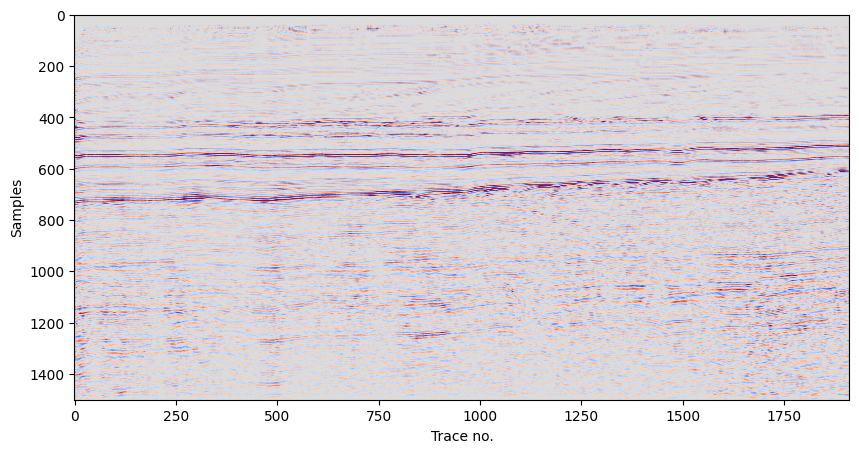

In [6]:
clip = abs(np.percentile(data, 0.999))   # default clip value

plt.figure(figsize=(10,5))
plt.imshow(data,interpolation='bilinear',aspect='auto',vmin=-clip,vmax=clip,cmap='coolwarm')
plt.ylabel('Samples')
plt.xlabel('Trace no.')

Let's make a function to plot seismic data (I'll show later on a quicker way to make plots):

In [7]:
def plot_seismic(inputseis, twt, name, colr='seismic', clip_val=None):
    ntraces = np.shape(inputseis)[1]
    if clip_val is None:
        clip_val = abs(np.percentile(inputseis, 0.9)) # default clip value
    f, ax = plt.subplots(figsize=(16,6))
    im = ax.imshow(
        inputseis, interpolation='bilinear', aspect='auto',
        cmap=colr, extent=(0,ntraces,twt[-1],twt[0]),
        vmin=-clip_val,vmax=clip_val)
    plt.xlabel('Trace no.'), plt.ylabel('Two-way time [ms]')
    plt.title(name), plt.grid(), plt.colorbar(im)

In the function above you can also choose your preferred colormaps (it defaults to the classic red-blue seismic map). The default is the classical red-white-blue (`seismic`), other nice colormaps are `Greys`, `coolwarm`, `RdGy` (and don't forget to read these  essays on colormaps by [Matteo](http://nbviewer.ipython.org/github/mycarta/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb) and [Jake]( https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
)).

All the colormaps available in [matplotlib](http://matplotlib.org/) are listed here:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps 

For example, let's plot the same line between 0.5 and 1.5 seconds of data using a different colormap:

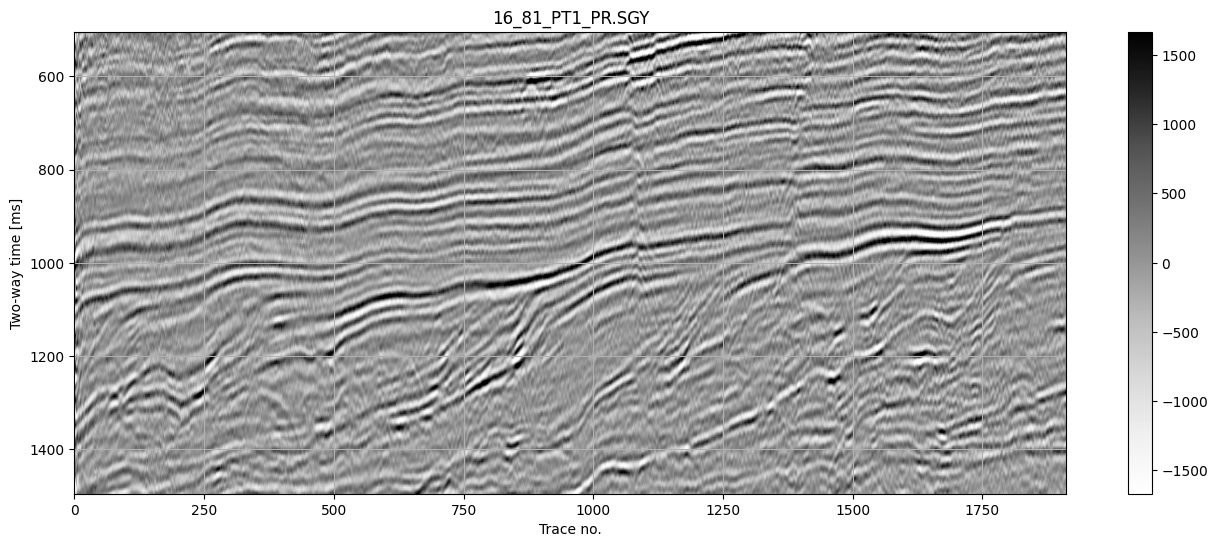

In [8]:
dd = (twt>500) & (twt<1500)
plot_seismic(data[dd,:],twt[dd],filename,colr='Greys',clip_val=clip)

### comparison displays

Just for fun, let's build another two copies of the line above, we'll change them a bit and compare to one another.

The first one will be a noisy version of dhe data above, the second will be smoother instead (code for adding noise and smoothing the data taken straight from [this notebook by Matt Hall](http://nbviewer.ipython.org/github/agile-geoscience/notebooks/blob/master/Filtering_horizons.ipynb):

In [9]:
t1, t2 = 1000, 1500
line_zoom = data[(twt>=t1) & (twt<=t2),:]
noise = np.random.uniform(-1500,1500, line_zoom.shape)
line_noise = line_zoom + noise

import scipy.signal
kernel = np.ones((5,5)) / 25
line_filt = scipy.signal.convolve2d(line_zoom, kernel)

This is the code to display the 3 lines together:

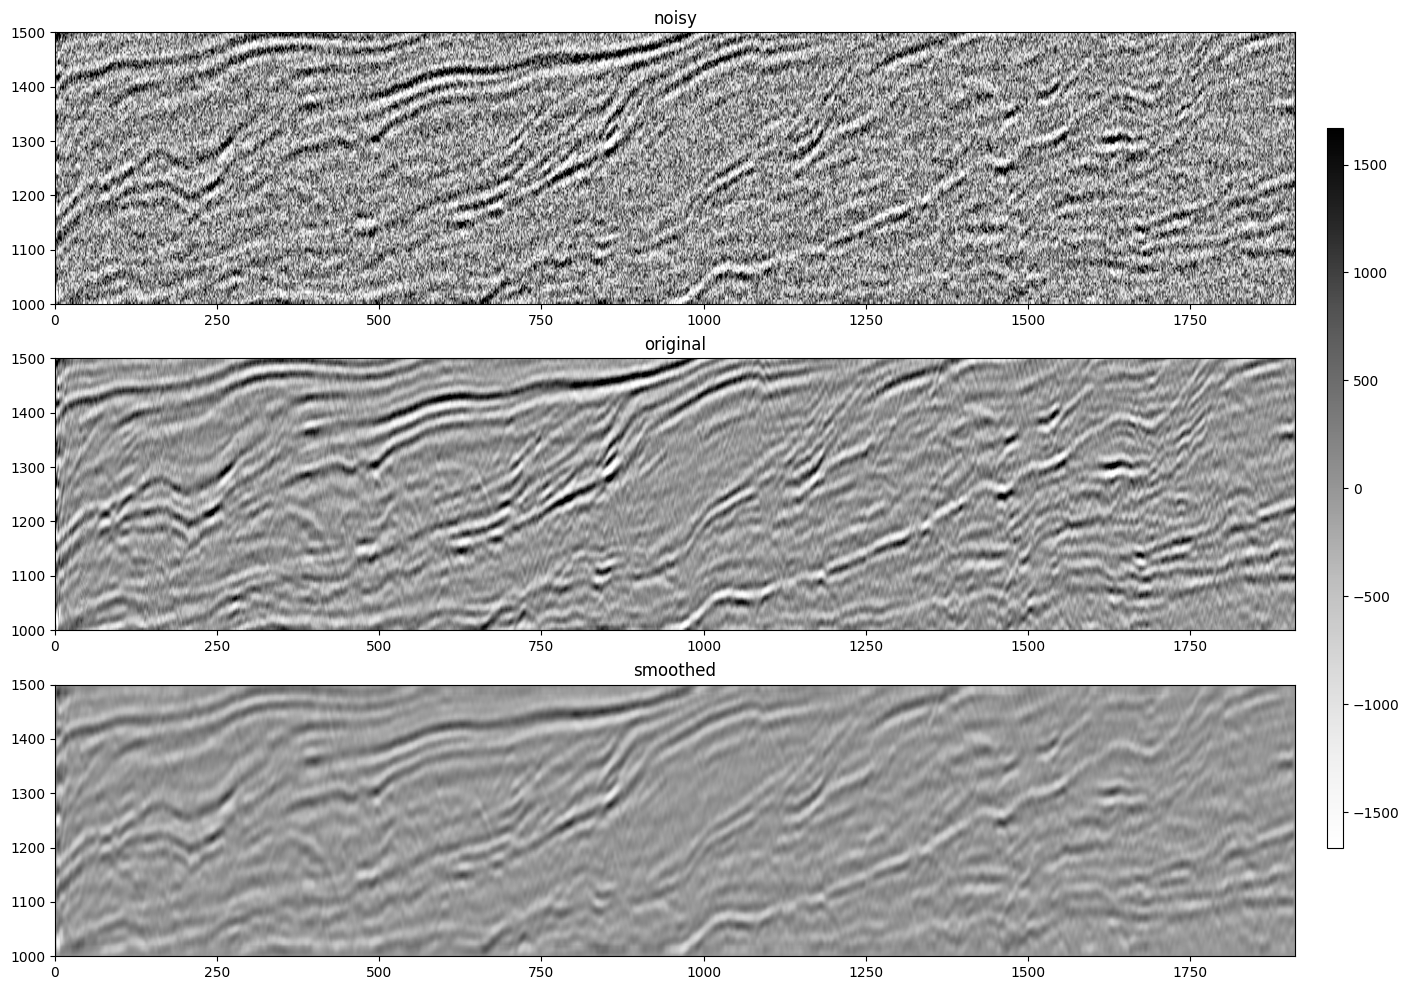

In [10]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(16,12),facecolor='w')
im0=ax[0].imshow(line_noise,interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
im1=ax[1].imshow(line_zoom, interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
im2=ax[2].imshow(line_filt, interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
ax[0].set_title('noisy'), ax[1].set_title('original'), ax[2].set_title('smoothed')
cax = f.add_axes([0.92, 0.2, 0.01, 0.6])
f.colorbar(im0, cax=cax, orientation='vertical')

### reading 3D datasets

In [11]:
remote_file = 'https://github.com/aadm/geophysical_notes/raw/master/3d_nearstack.sgy'
response = requests.get(remote_file)
if response.raise_for_status() is False:
    print('download error')
    
# create a temporary file to save the downloaded SEGY file
with NamedTemporaryFile(delete=False) as tmp:
    tmp.write(response.content)
    local_file = tmp.name

with segyio.open(local_file, iline=41, xline=21) as segyfile:
    data = segyio.tools.cube(segyfile)
    ntraces = segyfile.tracecount
    sr = segyio.tools.dt(segyfile)/1e3
    nsamples = segyfile.samples.size
    twt = segyfile.samples + 1500
    size_mb= data.nbytes/1024**2
    inlines = segyfile.ilines/1000
    crosslines = segyfile.xlines

# remove local files
os.remove(local_file)

The information I have on these two cubes are:

* inline information in byte 41 (and multiplide by 1000), crossline in 21, first sample at 1500 ms 
* inline: 1300-1500, every 2
* xline: 1500-2000, every 2
* time: 1500-2500 ms
* total 25351 traces for each subcube

Compared to older libraries (obspy) segyio reads all the relevant information and gives me back a nice 3D numpy array together with inlines and crosslines -- check it out:

In [12]:
print('Inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(inlines.size,inlines.min(),inlines.max()))
print('Crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(crosslines.size,crosslines.min(),crosslines.max()))
print('First, last sample twt: {0}, {1} s'.format(twt[0],twt[-1]))
print('Number of traces: {0}, samples: {1}, sample rate: {2} s'.format(ntraces,nsamples,sr))

Inlines: 101, min=1300, max=1500
Crosslines: 251, min=1500, max=2000
First, last sample twt: 1500.0, 2496.0 s
Number of traces: 25351, samples: 250, sample rate: 4.0 s


The Numpy array `seis` has now this shape:

In [13]:
print(data.shape)

(101, 251, 250)


The first dimension is inlines, then crosslines and finally time:

* 101 inlines x 251 crosslines x 250 twt samples 

I have found that converting the numpy array with seismic traces to an _xarray_ (need to install the `xarray` library first) makes my life much easier, with proper labelling and easy plots (so we can avoid defining our own `plot_seismic` function and use the capabilities of _xarray_):

In [14]:
near = xr.DataArray(data,[('IL',inlines),('XL',crosslines),('TWT',twt)])

Plot an inline:

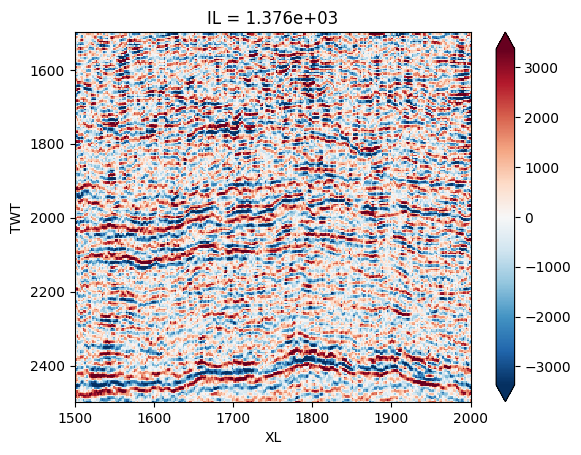

In [15]:
near.sel(IL=1376).plot.imshow(x='XL',y='TWT',robust=True,yincrease=False)

Super-easy to build a single plot showing one inline, one crossline and a timeslice (notice also the use of interpolation to get a smoother display and `plt.tight_layout()` for more separation between subplots):

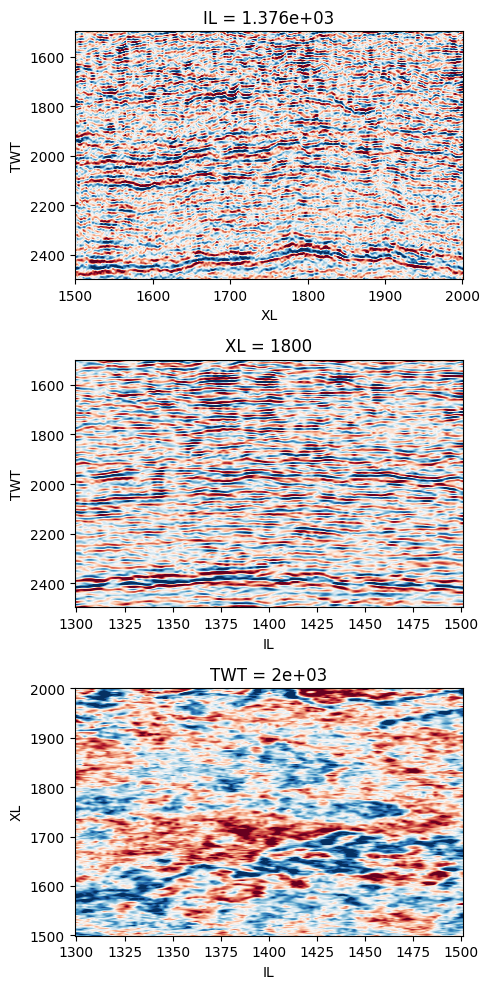

In [16]:
uu={'add_colorbar':False,'robust':True,'interpolation':'spline16'}
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(5,10))
near.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
near.sel(XL=1800).plot.imshow(x='IL',y='TWT',yincrease=False,ax=ax[1],**uu)
near.sel(TWT=2000).plot.imshow(x='IL',y='XL',ax=ax[2],**uu)
plt.tight_layout()

Without running the actual code and save another file to the github repo, here's how to save and compress in netCDF format the xarray cube:

```
near.to_netcdf('seismic_near.nc',encoding={'__xarray_dataarray_variable__':{'zlib':True}})
```

Then load it back again:

```
near=xr.open_dataarray('seismic_near.nc')
```

See also this notebook for a much more in-depth analysis of SEG-Y and alternative storage formats available in the Python ecosystem: <https://github.com/ar4/netcdf_segy/blob/master/notebooks/netcdf_segy.ipynb>

## dirty avo

Load the far-stack volume:

In [17]:
remote_file = 'https://github.com/aadm/geophysical_notes/raw/master/3d_farstack.sgy'
response = requests.get(remote_file)
if response.raise_for_status() is False:
    print('download error')
    
# create a temporary file to save the downloaded SEGY file
with NamedTemporaryFile(delete=False) as tmp:
    tmp.write(response.content)
    local_file = tmp.name

with segyio.open(local_file, iline=41, xline=21) as segyfile:
    data = segyio.tools.cube(segyfile)
    ntraces = segyfile.tracecount
    sr = segyio.tools.dt(segyfile)/1e3
    nsamples = segyfile.samples.size
    twt = segyfile.samples + 1500
    size_mb= data.nbytes/1024**2
    inlines = segyfile.ilines/1000
    crosslines = segyfile.xlines

# remove local files
os.remove(local_file)

and convert it to an xarray:

In [18]:
far = xr.DataArray(data,[('IL',inlines),('XL',crosslines),('TWT',twt)])

I will now select one inline from Near and Far volumes then calculate AVO Intercept and Gradient using a simple Shuey 2-term approach (see also my other notes on [AVO attributes](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/avo_attributes.ipynb)):

In [19]:
near_il = near.sel(IL=1376)
far_il = far.sel(IL=1376)

An=np.sin(np.radians(5))**2
Af=np.sin(np.radians(30))**2
G = (far_il - near_il)/(Af-An)
I = near_il - G*An

Display the Intercept and Gradient inline and crossplot the two attributes:

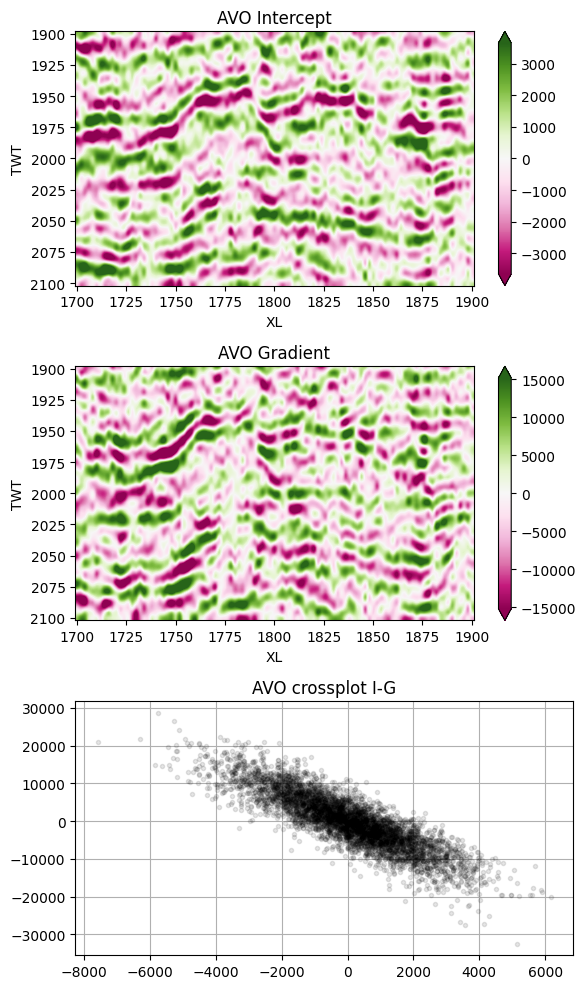

In [20]:
Izoom=I.sel(TWT=slice(1900,2100),XL=slice(1700,1900))
Gzoom=G.sel(TWT=slice(1900,2100),XL=slice(1700,1900))

uu={'add_colorbar':True,'robust':True,'interpolation':'spline16','cmap':'PiYG'}

f, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,10))
Izoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
Gzoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[2].plot(Izoom,Gzoom,'.k',alpha=0.1)
ax[0].set_title('AVO Intercept')
ax[1].set_title('AVO Gradient')
ax[2].set_title('AVO crossplot I-G')
ax[2].grid()
plt.tight_layout()

## amplitude spectra

The following are functions to compute 1D and 2D arrays amplitude spectra and display it (with code friendly stolen from the usual suspects [Matt & Evan](http://www.agilescientific.com/)):

In [21]:
def ampspec(signal,sr,smooth=False):
    '''
    ampspec (C) aadm 2016
    Calculates amplitude spectrum of a signal with FFT optionally smoothed via cubic interpolation.

    INPUT
    signal: 1D numpy array
    sr: sample rate in ms
    smooth: True or False

    OUTPUT
    freq: frequency
    amp: amplitude
    '''

    SIGNAL = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.size, d=sr*0.001)
    keep = freq>=0
    SIGNAL = np.abs(SIGNAL[keep])
    freq = freq[keep]
    if smooth:
        freq0=np.linspace(freq.min(),freq.max()/2,freq.size*10)
        f = interp1d(freq, SIGNAL, kind='cubic')
        return freq0, f(freq0)
    else:
        return freq, SIGNAL

def fullspec(data,sr):
    '''
    fullspec (C) aadm 2016-2018
    Calculates amplitude spectrum of 2D numpy array.

    INPUT
    data: 2D numpy array, shape=(traces, samples)
    sr: sample rate in ms

    OUTPUT
    freq: frequency
    amp: amplitude
    db: amplitude in dB scale
    f_peak: average peak frequency
    '''
    amps, peaks = [], []
    for i in range(data.shape[0]):
        trace = data[i,:]
        freq, amp = ampspec(trace,sr)
        peak = freq[np.argmax(amp)]
        amps.append(amp)
        peaks.append(peak)
    amp0 = np.mean(np.dstack(amps), axis=-1)
    amp0 = np.squeeze(amp0)
    db0 = 20 * np.log10(amp0)
    db0 = db0 - np.amax(db0)
    f_peak = np.mean(peaks)
    print('freq peak: {:.2f} Hz'.format(f_peak))
    return freq,amp0,db0,f_peak

def plot_ampspec(freq,amp,f_peak,name=None):
    '''
    plot_ampspec (C) aadm 2016-2018
    Plots amplitude spectrum calculated with fullspec (aageofisica.py).

    INPUT
    freq: frequency
    amp: amplitude
    f_peak: average peak frequency
    '''
    db = 20 * np.log10(amp)
    db = db - np.amax(db)
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),facecolor='w')
    ax[0].plot(freq, amp, '-k', lw=2)
    ax[0].set_ylabel('Power')
    ax[1].plot(freq, db, '-k', lw=2)
    ax[1].set_ylabel('Power (dB)')
    for aa in ax:
        aa.set_xlabel('Frequency (Hz)')
        aa.set_xlim([0,np.amax(freq)/1.5])
        aa.grid()
        aa.axvline(f_peak, color='r', ls='-')
        if name!=None:
            aa.set_title(name, fontsize=16)

def plot_ampspec2(freq1,amp1,f_peak1,freq2,amp2,f_peak2,name1=None,name2=None):
    '''
    plot_ampspec2 (C) aadm 2016-2018
    Plots overlay of 2 amplitude spectra calculated with fullspec.

    INPUT
    freq1, freq2: frequency
    amp1, amp2: amplitude spectra
    f_peak1, f_peak2: average peak frequency
    '''
    db1 = 20 * np.log10(amp1)
    db1 = db1 - np.amax(db1)
    db2 = 20 * np.log10(amp2)
    db2 = db2 - np.amax(db2)
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),facecolor='w')
    if name1 is not None:
        label1='{:s} Fp={:.0f} Hz'.format(name1,f_peak1)
        label2='{:s} Fp={:.0f} Hz'.format(name2,f_peak2)
    else:
        label1='Fp={:.0f} Hz'.format(f_peak1)
        label2='Fp={:.0f} Hz'.format(f_peak2)
    ax[0].plot(freq1, amp1, '-k', lw=2, label=label1)
    ax[0].plot(freq2, amp2, '-r', lw=2, label=label2)
    ax[0].fill_between(freq1,0,amp1,lw=0, facecolor='k',alpha=0.25)
    ax[0].fill_between(freq2,0,amp2,lw=0, facecolor='r',alpha=0.25)
    ax[0].set_ylabel('Power')
    ax[1].plot(freq1, db1, '-k', lw=2, label=label1)
    ax[1].plot(freq2, db2, '-r', lw=2,label=label2)
    lower_limit=np.min(ax[1].get_ylim())
    ax[1].fill_between(freq1, db1, lower_limit, lw=0, facecolor='k', alpha=0.25)
    ax[1].fill_between(freq2, db2, lower_limit, lw=0, facecolor='r', alpha=0.25)
    ax[1].set_ylabel('Power (dB)')
    for aa in ax:
        aa.set_xlabel('Frequency (Hz)')
        aa.set_xlim([0,np.amax(freq)/1.5])
        aa.grid()
        aa.axvline(f_peak1, color='k', ls='-')
        aa.axvline(f_peak2, color='r', ls='-')
        aa.legend(fontsize='small')

Here's how to use the `ampspec` function to compute the amplitude spectrum of one trace:

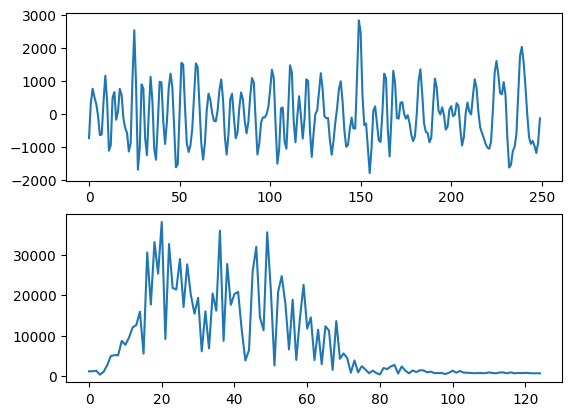

In [22]:
tr = far.sel(IL=1320, XL=1600).data
f,ax = plt.subplots(2)
ax[0].plot(tr)
ax[1].plot(ampspec(tr,sr)[1])

freq peak: 37.99 Hz
freq peak: 27.89 Hz


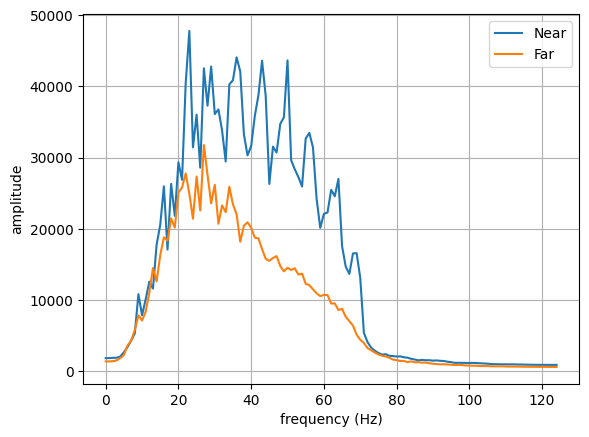

In [23]:
line_near = near.sel(IL=1320).data
line_far  = far.sel(IL=1320).data

f,ax = plt.subplots()
ax.plot(fullspec(line_near, sr)[1],label='Near')
ax.plot(fullspec(line_far, sr)[1],label='Far')
ax.set_ylabel('amplitude')
ax.set_xlabel('frequency (Hz)')
ax.grid()
ax.legend()

The function `plot_ampspec` plots the frequency spectrum in bot linear and dB scales, plus also draws a red marker corresponding to the peak frequency:

freq peak: 37.99 Hz


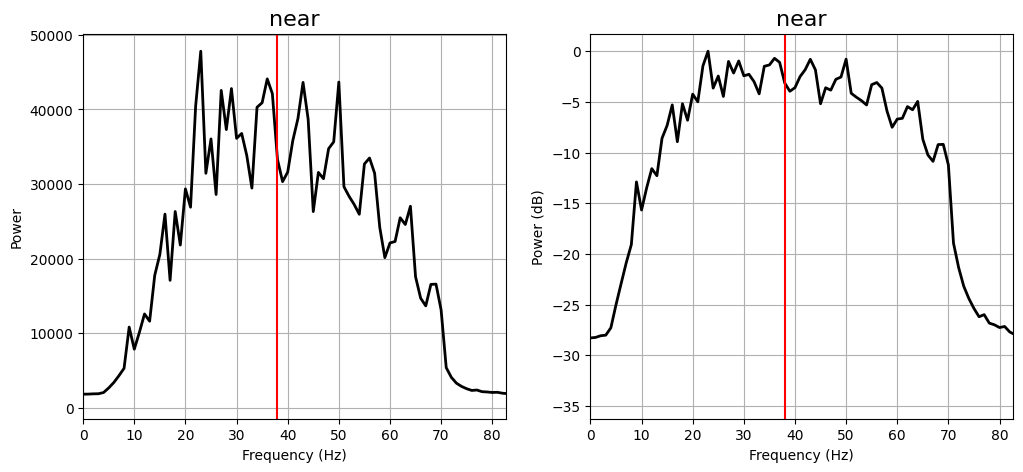

In [24]:
freq,amp,db,fpeak = fullspec(line_near, sr)
plot_ampspec(freq,amp,fpeak,name='near')

Let's see how the amplitude spectra changes for two time windows:

freq peak: 40.53 Hz
freq peak: 33.78 Hz


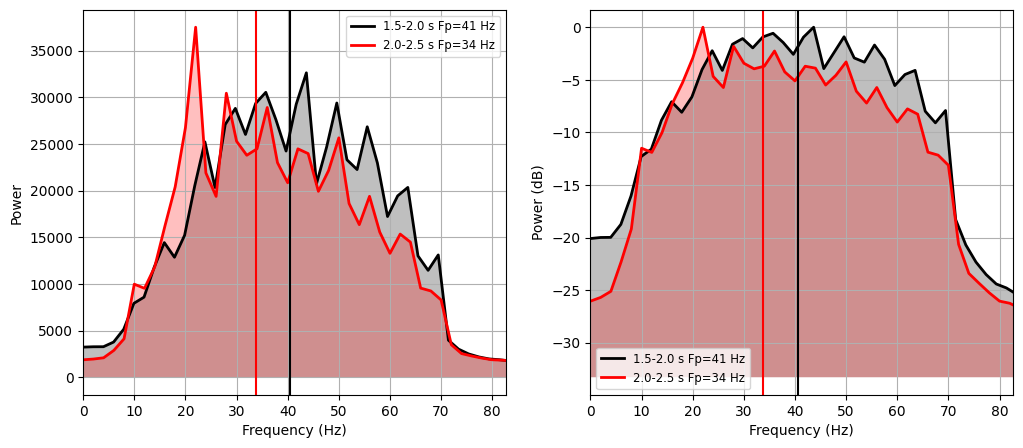

In [25]:
near0 = near.sel(IL=1320, TWT=slice(1500,2000)).data
near1 = near.sel(IL=1320, TWT=slice(2000,2500)).data

freq0, amp0, db0,fpeak0 = fullspec(near0, sr)
freq1, amp1, db1,fpeak1 = fullspec(near1, sr)

plot_ampspec2(
    freq0, amp0, fpeak0,
    freq1, amp1, fpeak1,
    name1='1.5-2.0 s',
    name2='2.0-2.5 s')